# QBUS2820 Assignment 2

**SID:** 510575452

In [21]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from forecast import histogram, qq_plot, intervalforecast,fanchart
from sklearn.metrics import mean_squared_error

# Loading in Dataset

In [3]:
# Step 1: Load the data, parse the "Quarter" column as dates
CPI_train_data = pd.read_csv('data/CPI_train.csv', index_col='Quarter')

# Parse dates with the format 'Mar-97'
CPI_train_data.index = pd.to_datetime(CPI_train_data.index, format='%b-%y', errors='coerce')

# Convert to quarterly periods
CPI_train_data.index = CPI_train_data.index.to_period('Q')

CPI_train_data

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0
...,...
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5


# EDA

## Looking at Key Characteristics of the dataset

In [4]:
CPI_train_data.head()

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0


In [5]:
CPI_train_data.tail()

,CPI
Quarter,
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5
2021Q3,126.2
2021Q4,125.8


In [6]:
CPI_train_data.columns

Index(['CPI'], dtype='object')

In [7]:
CPI_train_data.shape

(100, 1)

## Data Cleaning

### Removing null values

In [8]:
clean_CPI_train_data = CPI_train_data.dropna()

## Looking at the information of the dataset

In [9]:
clean_CPI_train_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 100 entries, 1997Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


## Looking at the description of the dataset

In [10]:
clean_CPI_train_data.describe()

,CPI
count,100.000000
mean,113.704000
std,9.187496
min,93.100000
25%,105.875000
50%,116.600000
75%,120.350000
max,126.200000


## Checking for Null Value

In [11]:
clean_CPI_train_data.isnull().sum()

CPI    0
dtype: int64

## Looking at the trend of the data

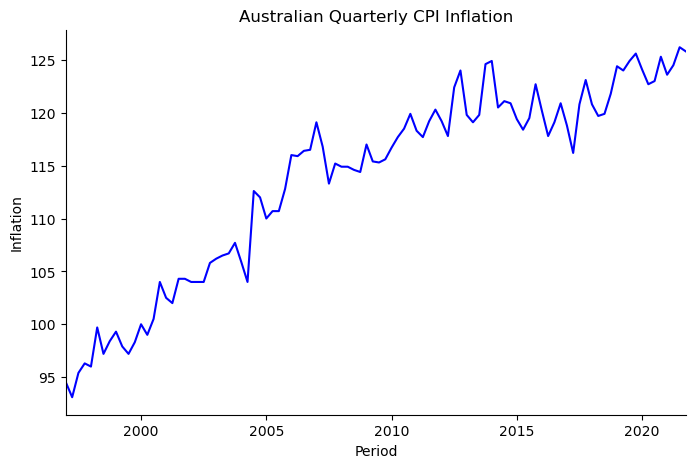

In [12]:
y = clean_CPI_train_data['CPI']

fig, ax = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax)
ax.set_xlabel('Period')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Testing for Stationary Points

**Hypothesis Testing** using **Augmented Dickey-Fuller**

$H_0:$ The time series is non-stationary.


$H_A:$ The time series is stationary.


**Threshold:**


$\alpha = 0.05$

In [41]:
adf_test = adfuller(CPI_train_data['CPI'], autolag='t-stat')
print(f'ADF P-value: {round(adf_test[1], 4)}')

ADF P-value: 0.212


Since the p-value $> 0.05$ ($\alpha$), we fail to reject the null hypothesis which suggests that the time series is non-stationary.  Hence, we will be using model smoothing to forecast the future predictions of the Australian CPI Inflation. 

# Model Smoothing

## Simple Exponential Smoothing 

In [13]:
simple_exponential_smoothing = SimpleExpSmoothing(y, initialization_method="estimated")
fitted_model = simple_exponential_smoothing.fit(optimized=True)
fitted_model.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,SimpleExpSmoothing,SSE,388.993
Optimized:,True,AIC,139.839
Trend:,None,BIC,145.049
Seasonal:,None,AICC,140.260
Seasonal Periods:,None,Date:,"Wed, 16 Oct 2024"
Box-Cox:,False,Time:,13:18:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6496116,alpha,True
initial_level,94.341806,l.0,True


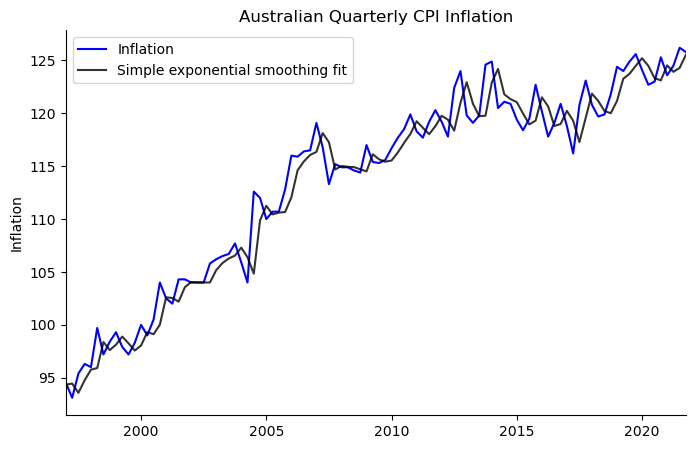

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
fitted = fitted_model.fittedvalues
fitted.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

### Model Diagnostics

#### Residual Plot

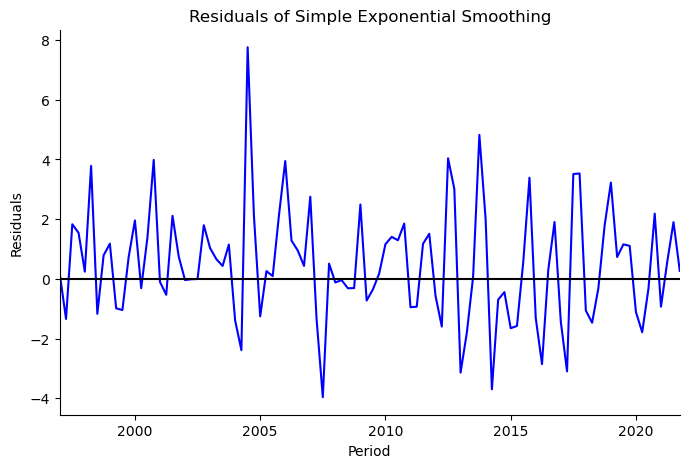

In [15]:
resid = y-fitted

fig, ax = plt.subplots(figsize=(8, 5))
resid.plot(color='b', ax=ax)
ax.set_xlabel('Period')
ax.set_ylabel('Residuals')
ax.set_title('Residuals of Simple Exponential Smoothing')
ax.set_xticks([], minor=True)
sns.despine()
plt.axhline(0, color='black')
plt.show()

#### Autocorrelation Plot

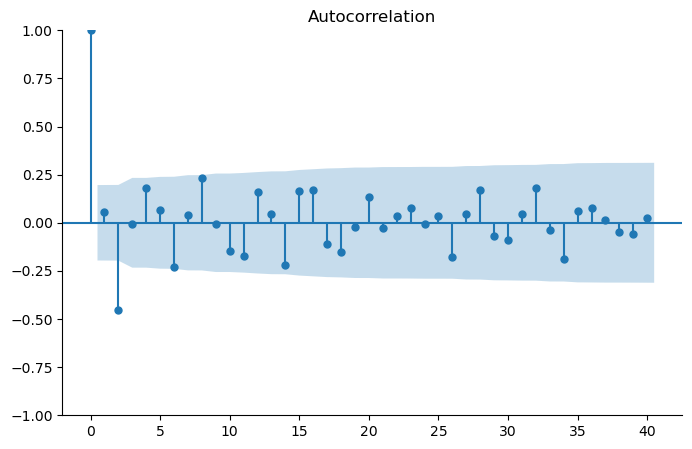

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

#### Histogram Plot

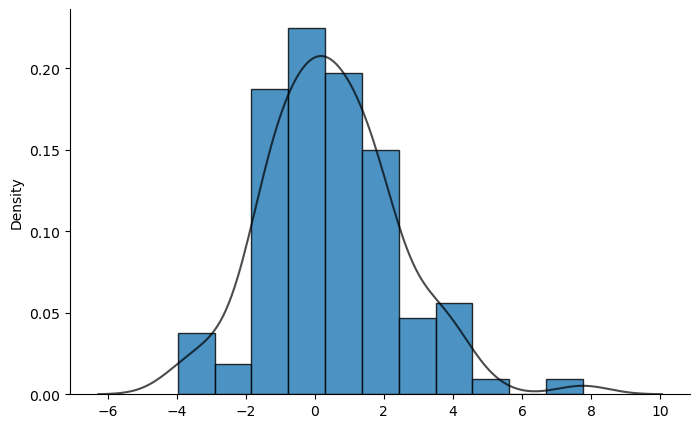

In [17]:
histogram(resid)
plt.show()

#### QQ-plot

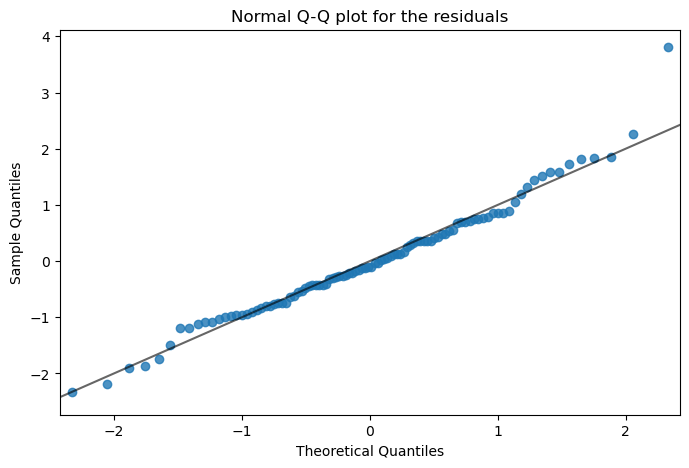

In [18]:
qq_plot(resid)
plt.show()

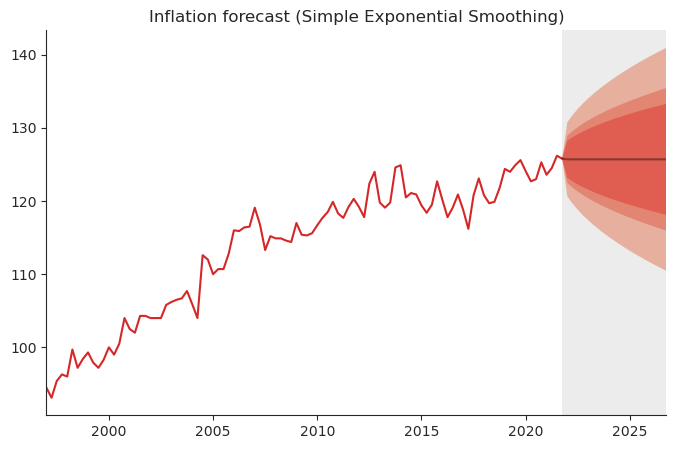

In [19]:
h = 20

test = pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')

pred = pd.Series(fitted_model.forecast(h), index=test)

intv1 = pd.DataFrame(intervalforecast(fitted_model, h, level=.8), index=test)
intv2 = pd.DataFrame(intervalforecast(fitted_model, h, level=.9), index=test)
intv3 = pd.DataFrame(intervalforecast(fitted_model, h, level=.99), index=test)

fig, ax = fanchart(y, pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Inflation forecast (Simple Exponential Smoothing)')

sns.despine()
plt.show()

## Holt-Winters Smoothing

# Code Chunk to Run Tests for Predictions

In [20]:
# CPI_test = pd.read_csv('CPI_test.csv')
# # YOUR CODE HERE : code that produces the test error
# print (test_error)